# Mini Modèle de Langage avec Apprentissage

Ce notebook implémente un petit réseau de neurones capable d'apprendre à comprendre et générer des phrases.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

print('✓ Imports réussis')

✓ Imports réussis


In [2]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum()

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

print('✓ Fonctions définies')

✓ Fonctions définies


In [3]:
class Tokenizer:
    def __init__(self):
        self.word_to_id = {'<PAD>': 0, '<UNK>': 1}
        self.id_to_word = {0: '<PAD>', 1: '<UNK>'}
        self.next_id = 2
    
    def fit(self, texts):
        for text in texts:
            for word in text.lower().split():
                if word not in self.word_to_id:
                    self.word_to_id[word] = self.next_id
                    self.id_to_word[self.next_id] = word
                    self.next_id += 1
    
    def encode(self, text):
        return [self.word_to_id.get(word.lower(), 1) for word in text.split()]
    
    def decode(self, ids):
        return ' '.join([self.id_to_word.get(id, '<UNK>') for id in ids])
    
    @property
    def vocab_size(self):
        return len(self.word_to_id)

print('✓ Tokenizer défini')

✓ Tokenizer défini


In [4]:
class MiniLanguageModel:
    def __init__(self, vocab_size, embedding_dim=20, hidden_dim=30, context_length=3):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.context_length = context_length
        
        self.embeddings = np.random.randn(vocab_size, embedding_dim) * 0.1
        self.W_hidden = np.random.randn(context_length * embedding_dim, hidden_dim) * 0.1
        self.b_hidden = np.zeros(hidden_dim)
        self.W_output = np.random.randn(hidden_dim, vocab_size) * 0.1
        self.b_output = np.zeros(vocab_size)
        
        self.v_embeddings = np.zeros_like(self.embeddings)
        self.v_W_hidden = np.zeros_like(self.W_hidden)
        self.v_b_hidden = np.zeros_like(self.b_hidden)
        self.v_W_output = np.zeros_like(self.W_output)
        self.v_b_output = np.zeros_like(self.b_output)
        
        self.loss_history = []
    
    def forward(self, context_ids):
        context_vectors = [self.embeddings[id] for id in context_ids]
        x = np.concatenate(context_vectors)
        
        self.hidden_input = x @ self.W_hidden + self.b_hidden
        self.hidden_output = relu(self.hidden_input)
        
        self.output_scores = self.hidden_output @ self.W_output + self.b_output
        
        probs = softmax(self.output_scores)
        
        self.last_context_ids = context_ids
        self.last_x = x
        
        return probs
    
    def backward(self, context_ids, target_id, learning_rate=0.01, momentum=0.9):
        probs = self.forward(context_ids)
        
        d_output = probs.copy()
        d_output[target_id] -= 1
        
        d_W_output = np.outer(self.hidden_output, d_output)
        d_b_output = d_output
        d_hidden_output = d_output @ self.W_output.T
        
        d_hidden_input = d_hidden_output * relu_derivative(self.hidden_input)
        d_W_hidden = np.outer(self.last_x, d_hidden_input)
        d_b_hidden = d_hidden_input
        d_x = d_hidden_input @ self.W_hidden.T
        
        d_embeddings = {}
        chunk_size = self.embedding_dim
        for i, word_id in enumerate(context_ids):
            start = i * chunk_size
            end = start + chunk_size
            if word_id not in d_embeddings:
                d_embeddings[word_id] = np.zeros(self.embedding_dim)
            d_embeddings[word_id] += d_x[start:end]
        
        self.v_W_output = momentum * self.v_W_output - learning_rate * d_W_output
        self.v_b_output = momentum * self.v_b_output - learning_rate * d_b_output
        self.v_W_hidden = momentum * self.v_W_hidden - learning_rate * d_W_hidden
        self.v_b_hidden = momentum * self.v_b_hidden - learning_rate * d_b_hidden
        
        self.W_output += self.v_W_output
        self.b_output += self.v_b_output
        self.W_hidden += self.v_W_hidden
        self.b_hidden += self.v_b_hidden
        
        for word_id, grad in d_embeddings.items():
            self.v_embeddings[word_id] = momentum * self.v_embeddings[word_id] - learning_rate * grad
            self.embeddings[word_id] += self.v_embeddings[word_id]
        
        loss = -np.log(probs[target_id] + 1e-10)
        return loss
    
    def train(self, texts, tokenizer, epochs=100, learning_rate=0.01, verbose=True):
        if verbose:
            print(f'Entraînement sur {len(texts)} phrases...')
        
        for epoch in range(epochs):
            total_loss = 0
            count = 0
            
            for text in texts:
                ids = tokenizer.encode(text)
                
                for i in range(len(ids) - self.context_length):
                    context = ids[i:i+self.context_length]
                    target = ids[i+self.context_length]
                    
                    loss = self.backward(context, target, learning_rate)
                    total_loss += loss
                    count += 1
            
            avg_loss = total_loss / max(count, 1)
            self.loss_history.append(avg_loss)
            
            if verbose and (epoch + 1) % 20 == 0:
                print(f'Époque {epoch+1:3d}/{epochs} | Perte: {avg_loss:.4f}')
        
        if verbose:
            print('Entraînement terminé !')
    
    def predict_next(self, context_text, tokenizer, top_k=5):
        ids = tokenizer.encode(context_text)[-self.context_length:]
        
        while len(ids) < self.context_length:
            ids.insert(0, 0)
        
        probs = self.forward(ids)
        
        top_indices = np.argsort(probs)[-top_k:][::-1]
        results = [(tokenizer.id_to_word[idx], probs[idx]) for idx in top_indices]
        
        return results
    
    def generate(self, start_text, tokenizer, length=10, temperature=0.8):
        ids = tokenizer.encode(start_text)
        
        for _ in range(length):
            context = ids[-self.context_length:]
            while len(context) < self.context_length:
                context.insert(0, 0)
            
            probs = self.forward(context)
            
            probs = np.power(probs, 1/temperature)
            probs = probs / probs.sum()
            
            next_id = np.random.choice(len(probs), p=probs)
            ids.append(next_id)
        
        return tokenizer.decode(ids)

print('✓ Modèle défini')

✓ Modèle défini


In [5]:
training_texts = [
    'le chat dort sur le canapé rouge',
    'le chat mange des croquettes',
    'le chat joue avec une balle',
    'le chien dort sur le tapis',
    'le chien mange de la viande',
    'le chien joue dans le jardin',
    'le chat noir dort beaucoup',
    'le chien brun court vite',
    'la balle rouge roule',
    'le canapé rouge est confortable',
    'le jardin est grand',
    'le tapis est doux'
]

print(f'Corpus : {len(training_texts)} phrases')

Corpus : 12 phrases


In [6]:
tokenizer = Tokenizer()
tokenizer.fit(training_texts)

print(f'Vocabulaire : {tokenizer.vocab_size} mots')
print(list(tokenizer.word_to_id.keys()))

Vocabulaire : 32 mots
['<PAD>', '<UNK>', 'le', 'chat', 'dort', 'sur', 'canapé', 'rouge', 'mange', 'des', 'croquettes', 'joue', 'avec', 'une', 'balle', 'chien', 'tapis', 'de', 'la', 'viande', 'dans', 'jardin', 'noir', 'beaucoup', 'brun', 'court', 'vite', 'roule', 'est', 'confortable', 'grand', 'doux']


In [7]:
model = MiniLanguageModel(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=15,
    hidden_dim=25,
    context_length=3
)

print('Modèle créé !')

Modèle créé !


In [8]:
print('AVANT entraînement :')
predictions = model.predict_next('le chat', tokenizer, top_k=3)
for word, prob in predictions:
    print(f'  {word:15s} {prob*100:5.1f}%')

AVANT entraînement :
  dort              3.2%
  chien             3.2%
  dans              3.2%


In [9]:
model.train(training_texts, tokenizer, epochs=200, learning_rate=0.05)

Entraînement sur 12 phrases...
Époque  20/200 | Perte: 3.2598
Époque  40/200 | Perte: 3.2349
Époque  60/200 | Perte: 3.2298
Époque  80/200 | Perte: 3.2275
Époque 100/200 | Perte: 3.2262
Époque 120/200 | Perte: 3.2253
Époque 140/200 | Perte: 3.2247
Époque 160/200 | Perte: 3.2243
Époque 180/200 | Perte: 3.2239
Époque 200/200 | Perte: 3.2237
Entraînement terminé !


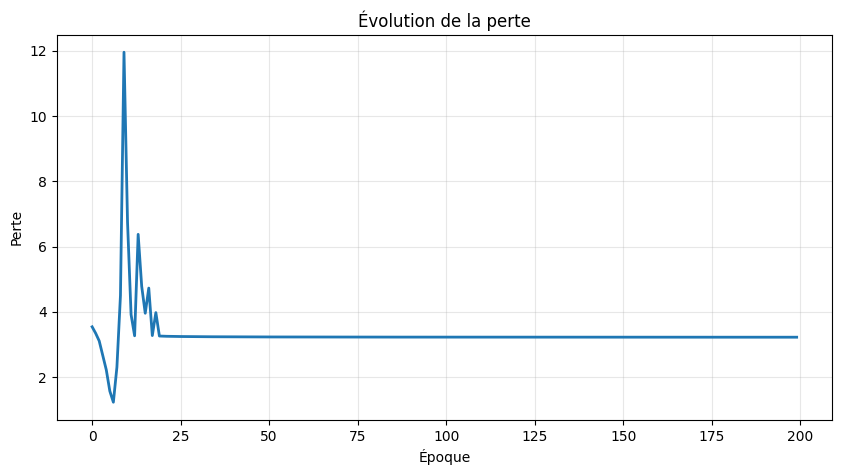

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(model.loss_history, linewidth=2)
plt.title('Évolution de la perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
print('APRÈS entraînement :')
for test in ['le chat', 'le chien', 'sur le']:
    predictions = model.predict_next(test, tokenizer, top_k=3)
    print(f'\nContexte : {test}')
    for word, prob in predictions:
        print(f'  {word:15s} {prob*100:5.1f}%')

APRÈS entraînement :

Contexte : le chat
  jardin          100.0%
  grand             0.0%
  viande            0.0%

Contexte : le chien
  grand           100.0%
  viande            0.0%
  jardin            0.0%

Contexte : sur le
  le               11.0%
  sur               6.7%
  jardin            3.9%


In [12]:
print('GÉNÉRATION DE TEXTE :\n')
for start in ['le chat', 'le chien']:
    generated = model.generate(start, tokenizer, length=7, temperature=0.6)
    print(f'{start} → {generated}')

GÉNÉRATION DE TEXTE :

le chat → le chat jardin sur le canapé sur dans jardin
le chien → le chien grand sur sur beaucoup roule de roule
